## 3.1 and 3.2: Load the filtered data from Lab 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hyperparameters import hyperparameters # Assuming this exists and works
import time
# Try importing CuPy
try:
    import cupy as cp
    gpu_available = True
    xp = cp  # Use CuPy for GPU computations
    print("CuPy found, using GPU.")
except ImportError:
    gpu_available = False
    xp = np
    print("CuPy not found, using NumPy on CPU.")

from Digital_twin import DigitalTwin # Assuming this exists, though it's less used in the vectorized version


hp = hyperparameters()

# Path to the CSV file
csv_file_path = 'filtered_low-pass_data-units.csv'
df = pd.read_csv(csv_file_path)

sample_rate = 40  # Hz
start_time = int(round(7.67 * sample_rate))
end_time = start_time + 30 * sample_rate

highlighted_data = df[start_time:end_time]
# Ensure time is relative and in seconds
df_time_pd = (highlighted_data['time'] - highlighted_data['time'].iloc[0]) / 1_000_000

# Apply a moving average filter to the 'xAccl' column
window_size = 11  # Define the window size for the moving average
df_theta_filtered_pd = highlighted_data['xAccl'].rolling(window=window_size).mean()

# Drop NaNs introduced by rolling window and reset index
df_theta_filtered_pd = df_theta_filtered_pd.iloc[window_size - 1:].reset_index(drop=True)
df_time_pd = df_time_pd.iloc[window_size - 1:].reset_index(drop=True)

# Sensor properties
sensor_max = 1024
sensor_min = -1024
sensor_range = sensor_max - sensor_min

######################
# 3.1: THE SENSOR DATA IS TRANSFORMED TO RADIANS
######################
offset_radians = 0.022
df_theta_radians_pd = (df_theta_filtered_pd - sensor_min) * (np.pi / sensor_range) - 0.5 * np.pi - offset_radians

# --- Convert relevant data to NumPy/CuPy arrays ---
df_theta_radians = xp.asarray(df_theta_radians_pd.values, dtype=xp.float64)
df_time = xp.asarray(df_time_pd.values, dtype=xp.float64) # Keep time for plotting

average_time_diff = df_time_pd.diff().mean()
print("Average time difference between samples:", average_time_diff)

CuPy found, using GPU.
Average time difference between samples: 0.025005243902439023


## 3.3 Find the initial condition
We have selected the part of the data where the pendulum is just about to drop.</br>
This means that:</br>
$\theta = \frac{1}{2}\pi$</br>
$\dot{\theta} = 0$

In [73]:
theta_init = df_theta_radians[0].item() # Get scalar value
theta_dot_init = 0.0 # Initial angular velocity assumption

print(f"Initial theta: {theta_init}, Initial theta_dot: {theta_dot_init}")


Initial theta: 1.4839507753070034, Initial theta_dot: 0.0


## Custom simulation code

In [75]:
def get_theta_double_dot_vectorized(xp, theta, theta_dot, l, m, c_air, c_c, g):
    """
    Computes the angular acceleration (theta_double_dot) - VECTORIZED.
    Accepts and returns xp arrays (xp can be numpy or cupy).
    """
    gravity_torque = -(g * xp.sin(theta)) / l
    denominator_cl = m * l**2
    # Avoid division by zero (add small epsilon if m or l could be zero)
    # denominator_cl = m * l**2 + 1e-12
    coulomb_friction = -((c_c * xp.sign(theta_dot)) / denominator_cl)
    air_friction = - (c_air * theta_dot) / denominator_cl
    theta_double_dot = gravity_torque + coulomb_friction + air_friction
    return theta_double_dot

def run_single_simulation_np(theta_init, theta_dot_init, c_air, c_c, l, num_steps, delta_t, m, g):
    """
    Runs a single simulation using NumPy, returns the theta trajectory.
    Designed for plotting purposes (output is NumPy array).
    """
    theta = float(theta_init) # Ensure scalar float
    theta_dot = float(theta_dot_init)
    sim_meas_np = np.zeros(num_steps, dtype=np.float64)

    # Ensure parameters are floats for NumPy calculations
    l_s, m_s, c_air_s, c_c_s, g_s = map(float, (l, m, c_air, c_c, g))
    delta_t_s = float(delta_t)

    for i in range(num_steps):
        # Use NumPy version of physics calculation
        gravity_torque = -(g_s * np.sin(theta)) / l_s
        denominator_cl = m_s * l_s**2
        # Basic check for division by zero
        if denominator_cl < 1e-12:
             coulomb_friction = 0.0
             air_friction = 0.0
        else:
            coulomb_friction = -((c_c_s * np.sign(theta_dot)) / denominator_cl)
            air_friction = - (c_air_s * theta_dot) / denominator_cl

        theta_double_dot = gravity_torque + coulomb_friction + air_friction

        theta_dot += theta_double_dot * delta_t_s
        theta += theta_dot * delta_t_s
        sim_meas_np[i] = theta

    return sim_meas_np

# --- Main Function ---

def find_best_pendulum_params_and_plot(
    c_air_range_np,
    c_c_range_np,
    l_range_np,
    df_theta_radians, # Input measurement data (NumPy array)
    delta_t,
    theta_init,
    theta_dot_init,
    m_const_val,        # Pendulum mass
    g_const_val,         # Gravity
    plot= True
):
    """
    Performs a grid search using GPU (if available) to find the best pendulum
    parameters (c_air, c_c, l) based on minimizing RMSE against measurements.
    Plots the result and returns the best parameters and lowest RMSE.

    Args:
        c_air_range_np (np.ndarray): Array defining air friction range.
        c_c_range_np (np.ndarray): Array defining Coulomb friction range.
        l_range_np (np.ndarray): Array defining length range.
        df_theta_radians (np.ndarray): Array of actual angle measurements (radians).
        delta_t (float): Time step for simulation.
        theta_init (float): Initial angle (radians).
        theta_dot_init (float): Initial angular velocity (radians/s).
        m_const_val (float): Mass of the pendulum.
        g_const_val (float): Acceleration due to gravity.

    Returns:
        tuple: (best_params, lowest_error) where best_params is a tuple
               (best_c_air, best_c_c, best_l), and lowest_error is the minimum RMSE.
    """
    print("Starting grid search function...")

    # --- Data Preparation on selected backend (xp) ---
    start_prep_time = time.time()
    theta_measurements = df_theta_radians
    g_const = xp.asarray(g_const_val, dtype=xp.float64)
    m_const = xp.asarray(m_const_val, dtype=xp.float64)

    # Create parameter grid
    c_air_grid, c_c_grid, l_grid = xp.meshgrid(
        xp.asarray(c_air_range_np, dtype=xp.float64),
        xp.asarray(c_c_range_np, dtype=xp.float64),
        xp.asarray(l_range_np, dtype=xp.float64),
        indexing='ij'
    )
    c_air_flat = c_air_grid.ravel()
    c_c_flat = c_c_grid.ravel()
    l_flat = l_grid.ravel()

    num_combinations = c_air_flat.size
    num_steps = len(theta_measurements)
    print(f"Grid Size: {len(c_air_range_np)} (c_air) x {len(c_c_range_np)} (c_c) x {len(l_range_np)} (l) = {num_combinations} combinations.")
    print(f"Simulating for {num_steps} time steps.")

    # Initialize state arrays for all simulations
    theta = xp.full(num_combinations, theta_init, dtype=xp.float64)
    theta_dot = xp.full(num_combinations, theta_dot_init, dtype=xp.float64)

    # Accumulate sum of squared errors incrementally
    sum_sq_errors = xp.zeros(num_combinations, dtype=xp.float64)

    prep_time = time.time() - start_prep_time
    print(f"Data preparation took {prep_time:.4f} seconds.")

    # --- Run Vectorized Simulation ---
    print("Starting vectorized simulation loop...")
    start_sim_time = time.time()

    for i in range(num_steps):
        theta_double_dot = get_theta_double_dot_vectorized(
            xp, theta, theta_dot, l_flat, m_const, c_air_flat, c_c_flat, g_const
        )
        theta_dot += theta_double_dot * delta_t
        theta += theta_dot * delta_t
        # Accumulate squared error relative to the i-th measurement point
        sum_sq_errors += (theta - theta_measurements[i])**2

    # Calculate final RMSE for all simulations
    mean_sq_error = sum_sq_errors / num_steps
    rmse_values = xp.sqrt(mean_sq_error)

    sim_time = time.time() - start_sim_time
    print(f"Vectorized simulation loop took {sim_time:.4f} seconds.")

    # --- Find Best Result ---
    start_analysis_time = time.time()
    min_error_idx = xp.argmin(rmse_values)

    # Get the minimum error and corresponding best parameters
    # Use .item() to convert from xp array scalar to Python float
    lowest_error = rmse_values[min_error_idx].item()
    best_c_air = c_air_flat[min_error_idx].item()
    best_c_c = c_c_flat[min_error_idx].item()
    best_l = l_flat[min_error_idx].item() # Will be constant if l_range has one element
    best_params = (best_c_air, best_c_c, best_l)

    analysis_time = time.time() - start_analysis_time
    print(f"Finding minimum error took {analysis_time:.4f} seconds.")

    print("\n--- Grid Search Results ---")
    print(f"Best Parameters (c_air, c_c, l): ({best_c_air:.6f}, {best_c_c:.6f}, {best_l:.6f})")
    print(f"Lowest Error (RMSE): {lowest_error:.6f}")

    # --- Run Simulation with Best Parameters (using NumPy for plotting) ---
    print("\nRunning single simulation with best parameters for plotting...")
    sim_measurements_best_np = run_single_simulation_np(
        theta_init, theta_dot_init, best_c_air, best_c_c, best_l,
        num_steps, delta_t, m_const_val, g_const_val
    )

    # --- Plotting ---
    print("Generating plot...")
    # Create time vector for plotting (using NumPy)
    df_time_np = np.arange(num_steps) * delta_t

    if plot:
        plt.figure(figsize=(12, 7))
        plt.plot(df_time_np, theta_measurements.get(), label='Actual Measurements', color='blue', linewidth=1.5)
        plt.plot(df_time_np, sim_measurements_best_np, label=f'Simulated (Best Fit: c_air={best_c_air:.5f}, c_c={best_c_c:.5f}, l={best_l:.5f})', color='red', linestyle='--', linewidth=1.5)
        plt.xlabel('Time (s)')
        plt.ylabel('Theta (radians)')
        plt.title('Comparison of Simulated (Best Fit) and Actual Measurements')
        plt.legend()
        plt.grid(True)
        plt.show() # Display the plot

    return best_params, lowest_error

## 3.4 Initial parameters
found in lab 1 and 2
PENDULUM_LENGHT = 0.237

Starting grid search function...
Grid Size: 50 (c_air) x 50 (c_c) x 50 (l) = 125000 combinations.
Simulating for 1190 time steps.
Data preparation took 0.0140 seconds.
Starting vectorized simulation loop...
Vectorized simulation loop took 2.0174 seconds.
Finding minimum error took 0.0070 seconds.

--- Grid Search Results ---
Best Parameters (c_air, c_c, l): (0.000449, 0.006531, 0.234694)
Lowest Error (RMSE): 0.126137

Running single simulation with best parameters for plotting...
Generating plot...


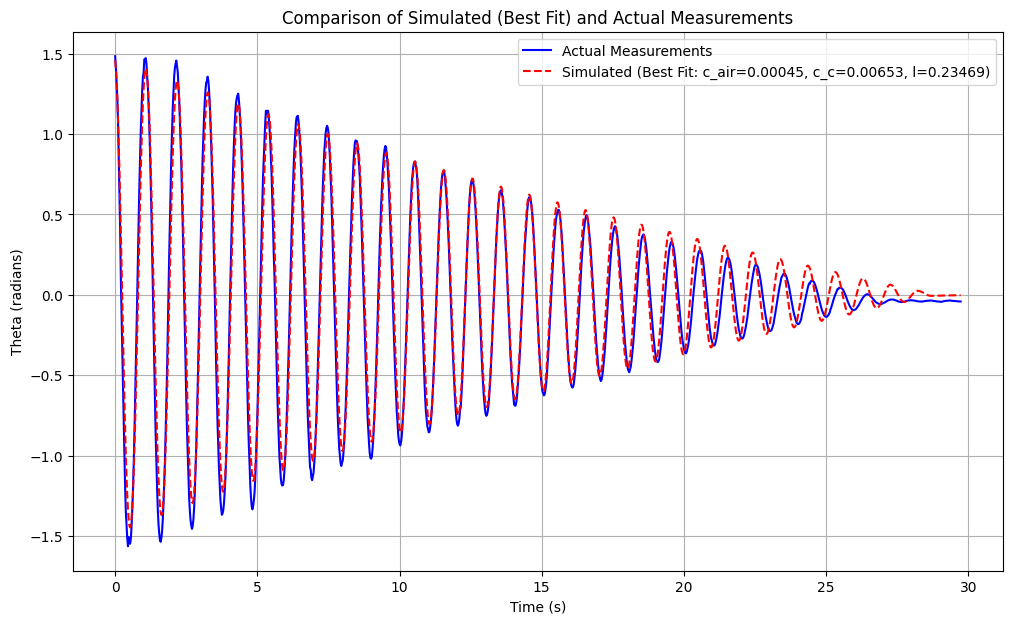

In [76]:
c_air_range_np = np.linspace(0.0, 0.002, 50, dtype=np.float64)  # High resolution grid
c_c_range_np = np.linspace(0.0, 0.04, 50, dtype=np.float64)   # High resolution grid
l_range_np = np.linspace(0.10, 0.40, 50, dtype=np.float64) # Single value for l

best_params, lowest_error = find_best_pendulum_params_and_plot(
    c_air_range_np,
    c_c_range_np,
    l_range_np,
    df_theta_radians,  # Input measurement data (CuPy array)
    delta_t=average_time_diff,
    theta_init=theta_init,
    theta_dot_init=theta_dot_init,
    m_const_val=hp.PENDULUM_MASS,
    g_const_val=hp.GRAVITY
)

In [119]:
c_air_range_np = np.linspace(0.000, 0.0006, 500, dtype=np.float64)  # High resolution grid
c_c_range_np = np.linspace(0.0, 0.01, 500, dtype=np.float64)   # High resolution grid
l_range_np = np.linspace(0.235, 0.243, 500, dtype=np.float64) # Single value for l

best_params, lowest_error = find_best_pendulum_params_and_plot(
    c_air_range_np,
    c_c_range_np,
    l_range_np,
    df_theta_radians,  # Input measurement data (CuPy array)
    delta_t=average_time_diff,
    theta_init=theta_init,
    theta_dot_init=theta_dot_init,
    m_const_val=hp.PENDULUM_MASS,
    g_const_val=hp.GRAVITY
)

Starting grid search function...
Grid Size: 500 (c_air) x 500 (c_c) x 500 (l) = 125000000 combinations.
Simulating for 1190 time steps.
Data preparation took 2.2813 seconds.
Starting vectorized simulation loop...


CUDADriverError: CUDA_ERROR_OUT_OF_MEMORY: out of memory

Starting grid search function...
Grid Size: 10 (c_air) x 10 (c_c) x 500 (l) = 50000 combinations.
Simulating for 1190 time steps.
Data preparation took 0.0020 seconds.
Starting vectorized simulation loop...
Vectorized simulation loop took 0.7712 seconds.
Finding minimum error took 0.0000 seconds.

--- Grid Search Results ---
Best Parameters (c_air, c_c, l): (0.001778, 0.002000, 0.240000)
Lowest Error (RMSE): 0.150942

Running single simulation with best parameters for plotting...
Generating plot...


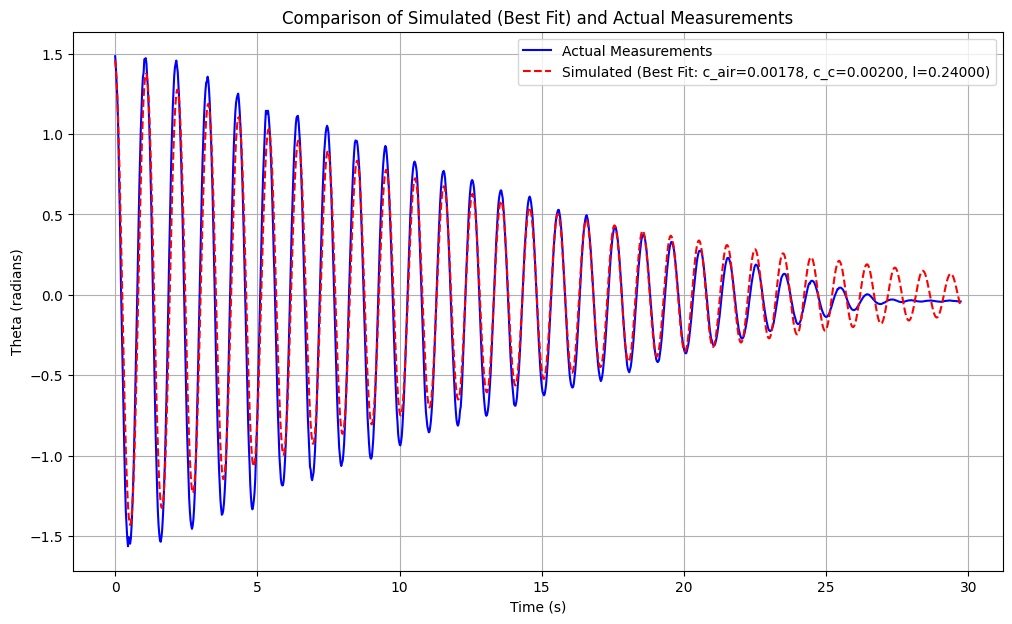

In [118]:
c_air_range_np = np.linspace(0.001, 0.002, 10, dtype=np.float64)  # High resolution grid
c_c_range_np = np.linspace(0.002, 0.027, 10, dtype=np.float64)   # High resolution grid
l_range_np = np.linspace(0.24, 0.242, 500, dtype=np.float64) # Single value for l

best_params, lowest_error = find_best_pendulum_params_and_plot(
    c_air_range_np,
    c_c_range_np,
    l_range_np,
    df_theta_radians,  # Input measurement data (CuPy array)
    delta_t=average_time_diff,
    theta_init=theta_init,
    theta_dot_init=theta_dot_init,
    m_const_val=hp.PENDULUM_MASS,
    g_const_val=hp.GRAVITY
)

In [70]:
def use_previous_best_params(
    best_params,
    deviation_percent,
    df_theta_radians, # Input measurement data (NumPy array)
    delta_t,
    theta_init,
    theta_dot_init,
    m_const_val,        # Pendulum mass
    g_const_val ):
    
    percent = float(deviation_percent) / 100 # Ensure it's a float
    c_air_previous = best_params[0]
    c_c_previous = best_params[1]
    l_previous = best_params[2]
    
    def get_min_value(value, percent=percent):
        return max(0,value - (value * percent))
    
    def get_max_value(value, percent=percent):
        return value + (value * percent)

    c_air_range_np = np.linspace(get_min_value(c_air_previous), get_max_value(c_air_previous), 500, dtype=np.float64)  # High resolution grid
    c_c_range_np = np.linspace(get_min_value(c_c_previous), get_max_value(c_c_previous), 500, dtype=np.float64)   # High resolution grid
    l_range_np = np.linspace(get_min_value(l_previous), get_max_value(l_previous), 50, dtype=np.float64) # Single value for l

    return find_best_pendulum_params_and_plot(
        c_air_range_np,
        c_c_range_np,
        l_range_np,
        df_theta_radians,  # Input measurement data (CuPy array)
        delta_t=average_time_diff,
        theta_init=theta_init,
        theta_dot_init=theta_dot_init,
        m_const_val=hp.PENDULUM_MASS,
        g_const_val=hp.GRAVITY,
        plot = False # Set to False to avoid plotting in this function
    )

actual_lowest_error = lowest_error
actual_best_params = best_params
percentages = [100, 50, 40, 30, 20, 10] # Percentages to test
for percentage in percentages:
    print(f"\nTesting with deviation percentage: {percentage}%")
    best_params, lowest_error = use_previous_best_params(
        best_params,
        percentage / 100.0,  # Convert to decimal
        df_theta_radians,  # Input measurement data (CuPy array)
        delta_t=average_time_diff,
        theta_init=theta_init,
        theta_dot_init=theta_dot_init,
        m_const_val=hp.PENDULUM_MASS,
        g_const_val=hp.GRAVITY
    )

    if lowest_error < actual_lowest_error:
        print(f"New best parameters found with lower RMSE: {lowest_error:.6f}")
        actual_lowest_error = lowest_error
        actual_best_params = best_params

print("\nFinal best parameters and lowest error:")
print(f"Best Parameters (c_air, c_c, l): ({actual_best_params[0]:.6f}, {actual_best_params[1]:.6f}, {actual_best_params[2]:.6f})")
print(f"Lowest Error (RMSE): {actual_lowest_error:.6f}")




Testing with deviation percentage: 100%
Starting grid search function...
Grid Size: 500 (c_air) x 500 (c_c) x 50 (l) = 12500000 combinations.
Simulating for 1190 time steps.
Data preparation took 0.0139 seconds.
Starting vectorized simulation loop...
Vectorized simulation loop took 52.1514 seconds.
Finding minimum error took 2.1149 seconds.

--- Grid Search Results ---
Best Parameters (c_air, c_c, l): (0.000409, 0.006378, 0.233804)
Lowest Error (RMSE): 0.124429

Running single simulation with best parameters for plotting...
Generating plot...
New best parameters found with lower RMSE: 0.124429

Testing with deviation percentage: 50%
Starting grid search function...
Grid Size: 500 (c_air) x 500 (c_c) x 50 (l) = 12500000 combinations.
Simulating for 1190 time steps.
Data preparation took 0.0000 seconds.
Starting vectorized simulation loop...
Vectorized simulation loop took 52.6603 seconds.
Finding minimum error took 2.1363 seconds.

--- Grid Search Results ---
Best Parameters (c_air, c_